In [1]:
import sklearn
import pickle
import numpy as np 
import torch 
from ClassificationModels.CNN_T import ResNetBaseline, get_all_preds, fit, UCRDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
from tslearn.datasets import UCR_UEA_datasets
import os 

# Parameters

In [2]:
#TODO Test and show results on Forest Cover Dataset 
dataset='NATOPS'

# Load Data

In [3]:

train_x,train_y, test_x, test_y=UCR_UEA_datasets().load_dataset(dataset)
train_x = train_x.reshape(-1,train_x.shape[-1],  train_x.shape[-2])
test_x = test_x.reshape(-1,test_x.shape[-1],  test_x.shape[-2])

In [4]:
print(test_y.shape)

(180,)


In [5]:
enc1=pickle.load(open(f'../../ClassificationModels/models/{dataset}/OneHotEncoder.pkl','rb'))
train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))

/home/jacqueline/.local/share/virtualenvs/TSInterpret-NXJYnQDU/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


# Model Training

In [6]:
n_pred_classes =train_y.shape[1]
train_dataset = UCRDataset(train_x.astype(np.float64),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)
model = ResNetBaseline(in_channels=test_x.shape[1], num_pred_classes=n_pred_classes)
model.load_state_dict(torch.load(f'../../ClassificationModels/models/{dataset}/ResNet'))
model.eval()

ResNetBaseline(
  (layers): Sequential(
    (0): ResNetBlock(
      (layers): Sequential(
        (0): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(24, 64, kernel_size=(8,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (1): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(64, 64, kernel_size=(5,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (2): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(64, 64, kernel_size=(3,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
      )
      (residual): Sequential(
        (0): Conv1dSamePadding(24, 64, kernel_size=(1

# Explanation Algo

In [7]:
item=test_x[1].reshape(1,test_x.shape[1],-1)
shape=item.shape
_item=  torch.from_numpy(item).float()
model.eval()
#y_target= model(_item).detach().numpy()
y_target = torch.nn.functional.softmax(model(_item)).detach().numpy()

/home/jacqueline/.local/share/virtualenvs/TSInterpret-NXJYnQDU/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [8]:
print(y_target)

[[3.97191116e-08 5.45776011e-08 1.01833805e-10 1.10801473e-07
  9.99103963e-01 8.95752397e-04]]


In [9]:
#from TSInterpret.InterpretabilityModels.TSInsight.CNN_PYT import ConvAutoencoder
#from TSInterpret.InterpretabilityModels.TSInsight.TSInsightPYT import TSInsightPYT

#autoencoder= ConvAutoencoder(1)
#autoencoder.load_state_dict(torch.load(f'../../ClassificationModels/models/{dataset}/TSInsightAutoencoder_cnn'))
#exp_model=TSInsightPYT(model,(shape[-2],shape[-1]),train_loader, test_loader, autoencoder=autoencoder)

In [10]:
from TSInterpret.InterpretabilityModels.TSInsight.TSInsightPYT import TSInsightPYT
exp_model=TSInsightPYT(model,(shape[-2],shape[-1]),(train_x,train_y), (test_x,test_y), autoencoder='cnn')

2022-08-01 15:02:15.081237: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-01 15:02:15.081258: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


INFO - Provided Datasets are Tuples. Create a Default DataLoader.
Batch torch.Size([1, 24, 51])
AE shape (24, 51)
torch.Size([1, 24, 42])
Reconstruction torch.Size([1, 24, 42])


RuntimeError: The size of tensor a (51) must match the size of tensor b (42) at non-singleton dimension 2

In [ ]:
# save model 
torch.save(exp_model.autoencoder.state_dict(), f'../../ClassificationModels/models/{dataset}/TSInsightAutoencoder_cnn')

In [ ]:
exp=exp_model.explain(item)

In [ ]:
np.count_nonzero(item.flatten()-exp.flatten())

600

In [ ]:
exp.shape

(1, 6, 100)

In [ ]:
item.shape

(1, 6, 100)

In [ ]:
#TODO Rewrite Plots for multiple layers


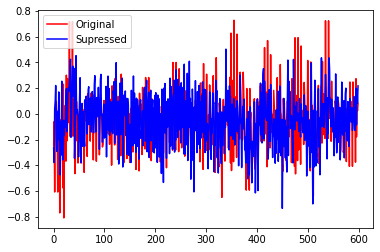

In [ ]:
exp_model.plot(item, exp)

In [ ]:
np.min(exp)

-0.73615646

In [ ]:
np.max(exp)

0.50339615

In [ ]:
#print(exp)

In [ ]:
#print(exp.shape)

# Plot Item 

In [ ]:

#exp_model.plot(item,np.argmax(y_target,axis=1)[0],exp,label)

In [ ]:
#xp_model.plot_in_one(item,np.argmax(y_target,axis=1)[0],exp,label)